<h1><center> || March Madness Notebook || </center></h1>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.utils import shuffle

from keras.layers import Input, Dense, Dropout, Flatten, Embedding, merge
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras.utils import to_categorical

%matplotlib inline

In [3]:
sns.set_style('darkgrid')

## Going to try and see what the eff we even have

In [4]:
sample_sub = pd.read_csv('../Datasets/SampleSubmissionStage1.csv')

In [5]:
sample_sub.head(3)

,ID,Pred
0,2014_1107_1110,0.5
1,2014_1107_1112,0.5
2,2014_1107_1113,0.5


So in 2014, team 1107 has 50% chance of beating 1110

In [8]:
detailed = pd.read_csv('Stage2UpdatedDataFiles/RegularSeasonDetailedResults.csv')
detailed.head(3)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23


In [9]:
detailed.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF'],
      dtype='object')

All of the columns with 'W' correspond to the winning team's stat in that category and likewise for all columns with 'L' and the losing team.

- WFGM - field goals made (by the winning team)
- WFGA - field goals attempted (by the winning team)
- WFGM3 - three pointers made (by the winning team)
- WFGA3 - three pointers attempted (by the winning team)
- WFTM - free throws made (by the winning team)
- WFTA - free throws attempted (by the winning team)
- WOR - offensive rebounds (pulled by the winning team)
- WDR - defensive rebounds (pulled by the winning team)
- WAst - assists (by the winning team)
- WTO - turnovers committed (by the winning team)
- WStl - steals (accomplished by the winning team)
- WBlk - blocks (accomplished by the winning team)
- WPF - personal fouls committed (by the winning team)

In [10]:
# Ultimately I'm actually going to drop all the seasons from before 2006.
# 2006 was when the "one-and-done" rule was implemented and the game changed significantly after.
# Plus some of the biggest upsets in tournament history have been in 2006 - current, so there may be something
# to learn from those seasons.

In [270]:
# Also going to be digging only into this season's stats since I believe that the turnover rate is high enough
# in NCAA basketball that each season now is basically an independent event.

In [11]:
# Coolio. So I learned from the Ames project that intelligent feature engineering is a HUGE part of model success.
# With that in mind, I'm not going to try to reinvent the wheel or anything, just use a couple of the advanced
# team analytics that are currently being used in the game today.

## **Feature engineering ——————————————————————————————**

References for these available below.
- Quick overview:
    - https://stats.nba.com/help/faq/
- Deeper dive:
    - http://hangtime.blogs.nba.com/2013/02/15/the-new-nba-comstats-advanced-stats-all-start-with-pace-and-efficiency/
- Actual glossary + formulas:
    - https://stats.nba.com/help/glossary/

### Starting with some building block efficiencies and possession stats

**Basic Possession Formula:**
- 0.96 x (( Field Goal Attempts ) + ( Turnovers ) + ( 0.44 x Free Throw Attempts ) - ( Offensive Rebounds )) 

In [13]:
detailed['WPos'] = detailed.apply(lambda row: 0.96*(row.WFGA + row.WTO + (0.44*row.WFTA) - row.WOR), axis=1)
detailed['LPos'] = detailed.apply(lambda row: 0.96*(row.LFGA + row.LTO + (0.44*row.LFTA) - row.LOR), axis=1)

**Offensive Efficiency Rating:**
- 100 x ( Points / Possessions )

In [14]:
detailed['WOffRtg'] = detailed.apply(lambda row: 100 * (row.WScore / row.WPos), axis=1)
detailed['LOffRtg'] = detailed.apply(lambda row: 100 * (row.LScore / row.LPos), axis=1)

**Defensive Efficiency Rating:**
- 100 x ( Opponent Points / Opponent Possessions )

In [15]:
detailed['WDefRtg'] = detailed.LOffRtg
detailed['LDefRtg'] = detailed.WOffRtg

 ### **"Four Factors"** are the box score derived metrics that correlate most closely with winning basketball games. 

**1. Shooting the Ball**
- Effective Field Goal Percentage = ( Field Goals Made + ( 0.5 x 3P Field Goals Made )) / ( Field Goal Attempts )

In [16]:
detailed['WEffFG'] = detailed.apply(lambda row: (row.WFGM + (0.5 * row.WFGM3)) / row.WFGA, axis=1)
detailed['LEffFG'] = detailed.apply(lambda row: (row.LFGM + (0.5 * row.LFGM3)) / row.LFGA, axis=1)

**2. Taking Care of the Ball**
- Turnover Rate = Turnovers / ( Field Goal Attempts + ( 0.44 x Free Throw Attempts ) + Turnovers )

In [17]:
detailed['WTOR'] = detailed.apply(lambda row: row.WTO / (row.WFGA + (0.44 * row.WFTA) + row.WTO), axis=1)
detailed['LTOR'] = detailed.apply(lambda row: row.LTO / (row.LFGA + (0.44 * row.LFTA) + row.LTO), axis=1)

In [19]:
# Checking to see that intuition should still hold up
detailed.WTOR.mean() < detailed.LTOR.mean()

True

**3. Offensive Rebounding**
- Offensive Rebounding Percentage = ( Offensive Rebounds ) / ( ( Offensive Rebounds ) + ( Opponent’s Defensive Rebounds ) )

In [20]:
detailed['WORP'] = detailed.apply(lambda row: row.WOR / (row.WOR + row.LDR), axis=1)
detailed['LORP'] = detailed.apply(lambda row: row.LOR / (row.LOR + row.WDR), axis=1)

**4. Getting to the Foul Line**
- Free Throw Rate = ( Free Throws Made ) / ( Field Goals Attempted )

In [21]:
detailed['WFTR'] = detailed.apply(lambda row: row.WFTM / row.WFGA, axis=1)
detailed['LFTR'] = detailed.apply(lambda row: row.LFTM / row.LFGA, axis=1)

In [23]:
detailed.head(3)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,WDefRtg,LDefRtg,WEffFG,LEffFG,WTOR,LTOR,WORP,LORP,WFTR,LFTR
0,2003,10,1104,68,1328,62,N,0,27,58,...,91.374269,94.545293,0.491379,0.433962,0.258659,0.223104,0.388889,0.294118,0.189655,0.301887
1,2003,10,1272,70,1393,63,N,0,26,62,...,96.792035,106.665691,0.483871,0.402985,0.155950,0.136674,0.375000,0.416667,0.161290,0.134328
2,2003,11,1266,73,1437,61,N,0,24,58,...,99.098045,119.262338,0.482759,0.321918,0.123824,0.126156,0.435897,0.543860,0.293103,0.191781


### Save room for PIE

What is **PIE**?

It is a simple metric that gives an excellent indication of performance at both the team and player level. It’s a major improvement to our EFF Rating. Notably 2 things changed: 
- (1) We included Personal Fouls, 
- (2) We added a denominator. 

We feel the key here is the denominator because it acts as an "automatic equalizer". Using the denominator, we find there is no need to consider the "PACE" of the statistics that are being analyzed. In its simplest terms, PIE shows what % of game events did that player or team achieve. The stats being analyzed are your traditional basketball statistics (PTS, REB, AST, TOV, etc..) _**A team that achieves more than 50% is likely to be a winning team.**_ In fact, a team’s PIE rating and a team’s winning percentage correlate at an R square of .908 which indicates a "strong" correlation.

( PTS + FGM + FTM - FGA - FTA + DREB + ( .5 x OREB ) + AST + STL + ( .5 x BLK ) - PF - TO ) 

**__DIVIDED BY__**

( GmPTS + GmFGM + GmFTM - GmFGA - GmFTA + GmDREB + ( .5 x GmOREB ) + GmAST + GmSTL + ( .5 x GmBLK ) - GmPF - GmTO )

In [24]:
detailed['WPIE'] = detailed.apply(lambda row: \
                                            (row.WScore + row.WFGM + row.WFTM - row.WFGA - row.WFTA + row.WDR + \
                                             (.5 * row.WOR) + row.WAst + row.WStl + (.5 * row.WBlk) - row.WPF - \
                                            row.WTO) \
                                            / \
                                            ((row.WScore + row.LScore) + (row.WFGM + row.LFGM) + (row.WFTM + row.LFTM)\
                                             - (row.WFGA + row.LFGA) - (row.WFTA + row.LFTA) + (row.WDR + row.LDR)\
                                             + (.5 * (row.WOR + row.LOR)) + (row.WAst + row.LAst) + (row.WStl + row.LStl)\
                                             + (.5 * (row.WBlk + row.LBlk)) - (row.WPF + row.LPF) - (row.WTO + row.LTO))\
                                            , axis=1)

In [25]:
detailed.WPIE.mean()

0.6507765759351386

In [26]:
detailed['LPIE'] = detailed.apply(lambda row: \
                                            (row.LScore + row.LFGM + row.LFTM - row.LFGA - row.LFTA + row.LDR + \
                                             (.5 * row.LOR) + row.LAst + row.LStl + (.5 * row.LBlk) - row.LPF - \
                                            row.LTO) \
                                            / \
                                            ((row.WScore + row.LScore) + (row.WFGM + row.LFGM) + (row.WFTM + row.LFTM)\
                                             - (row.WFGA + row.LFGA) - (row.WFTA + row.LFTA) + (row.WDR + row.LDR)\
                                             + (.5 * (row.WOR + row.LOR)) + (row.WAst + row.LAst) + (row.WStl + row.LStl)\
                                             + (.5 * (row.WBlk + row.LBlk)) - (row.WPF + row.LPF) - (row.WTO + row.LTO))\
                                            , axis=1)

In [27]:
detailed.LPIE.mean()

0.3492234240648273

In [29]:
detailed.head(3)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,WEffFG,LEffFG,WTOR,LTOR,WORP,LORP,WFTR,LFTR,WPIE,LPIE
0,2003,10,1104,68,1328,62,N,0,27,58,...,0.491379,0.433962,0.258659,0.223104,0.388889,0.294118,0.189655,0.301887,0.532847,0.467153
1,2003,10,1272,70,1393,63,N,0,26,62,...,0.483871,0.402985,0.155950,0.136674,0.375000,0.416667,0.161290,0.134328,0.602339,0.397661
2,2003,11,1266,73,1437,61,N,0,24,58,...,0.482759,0.321918,0.123824,0.126156,0.435897,0.543860,0.293103,0.191781,0.736434,0.263566


In [92]:
advanced_analytics = ['WPos',    'LPos',
                      'WOffRtg', 'LOffRtg',
                      'WDefRtg', 'LDefRtg',
                      'WEffFG',  'LEffFG',
                      'WTOR',    'LTOR',
                      'WORP',    'LORP',
                      'WFTR',    'LFTR',
                      'WPIE',    'LPIE']

**Don't forget to come up with a consistency rating if you have time!!**

_ Also put in some VIZZZZ here to show the advanced stats that we've got now _

## Now manipulating the structure of our data so we can have something to train the model on

In [125]:
games = []
for row in detailed.to_dict('records'):
    
    game = {}
    game['Season'] = row['Season']
    game['TeamID'] = row['WTeamID']
    game['OpponentID'] = row['LTeamID']
    game['Pos'] = row['WPos']
    game['Off_Rtg'] = row['WOffRtg']
    game['Def_Rtg'] = row['WDefRtg']
    game['Eff_FG'] = row['WEffFG']
    game['TOR'] = row['WTOR']
    game['ORP'] = row['WORP']
    game['FTR'] = row['WFTR']
    game['PIE'] = row['WPIE']
    game['Won'] = 1
    games.append(game)
    
    # Break
    
    game = {}
    game['Season'] = row['Season']
    game['TeamID'] = row['LTeamID']
    game['OpponentID'] = row['WTeamID']
    game['Pos'] = row['LPos']
    game['Off_Rtg'] = row['LOffRtg']
    game['Def_Rtg'] = row['LDefRtg']
    game['Eff_FG'] = row['LEffFG']
    game['TOR'] = row['LTOR']
    game['ORP'] = row['LORP']
    game['FTR'] = row['LFTR']
    game['PIE'] = row['LPIE']
    game['Won'] = 0
    games.append(game)

games_df = pd.DataFrame(games)
games_df.head(4)

,Def_Rtg,Eff_FG,FTR,ORP,Off_Rtg,OpponentID,PIE,Pos,Season,TOR,TeamID,Won
0,91.374269,0.491379,0.189655,0.388889,94.545293,1328,0.532847,71.9232,2003,0.258659,1104,1
1,94.545293,0.433962,0.301887,0.294118,91.374269,1104,0.467153,67.8528,2003,0.223104,1328,0
2,96.792035,0.483871,0.161290,0.375000,106.665691,1393,0.602339,65.6256,2003,0.155950,1272,1
3,106.665691,0.402985,0.134328,0.416667,96.792035,1272,0.397661,65.0880,2003,0.136674,1393,0


In [237]:
# Just doing a quick check to make sure that we have everything duplicated aka from both perspectives.
games_df.shape[0] == (2 * detailed.shape[0])

True

In [127]:
games_df.corr().loc['Won', :].sort_values(ascending = False)

Won           1.000000
PIE           0.775196
Off_Rtg       0.579504
Eff_FG        0.476299
FTR           0.316513
ORP           0.174195
TeamID        0.026653
Season        0.000000
Pos          -0.023097
OpponentID   -0.026653
TOR          -0.156338
Def_Rtg      -0.579504
Name: Won, dtype: float64

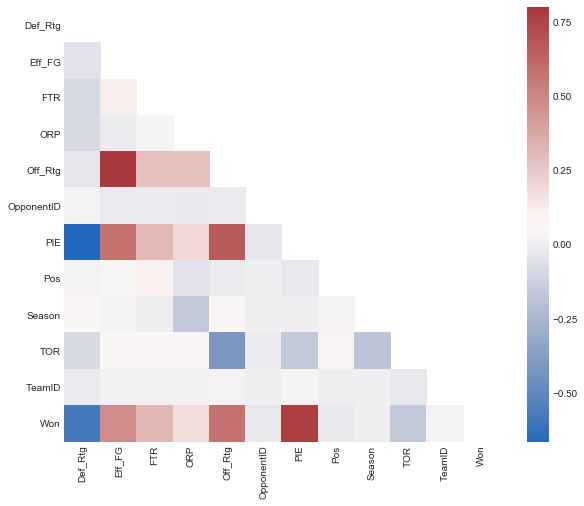

In [167]:
plt.figure(figsize=(10,8))

corr = games_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmax=.8, square=True, cmap='vlag')

In [168]:
games_df.head(3)

,Def_Rtg,Eff_FG,FTR,ORP,Off_Rtg,OpponentID,PIE,Pos,Season,TOR,TeamID,Won
0,91.374269,0.491379,0.189655,0.388889,94.545293,1328,0.532847,71.9232,2003,0.258659,1104,1
1,94.545293,0.433962,0.301887,0.294118,91.374269,1104,0.467153,67.8528,2003,0.223104,1328,0
2,96.792035,0.483871,0.161290,0.375000,106.665691,1393,0.602339,65.6256,2003,0.155950,1272,1


In [272]:
# Converting seed stuff to usable format

seeds = pd.read_csv('Stage2UpdatedDataFiles/NCAATourneySeeds.csv')
seeds['Seed'] = seeds['Seed'].apply(lambda seed: int(seed[1:3]))
seeds.head(3)

,Season,Seed,TeamID
0,1985,1,1207
1,1985,2,1210
2,1985,3,1228


In [280]:
with_team_seed = pd.merge(games_df, seeds, on=['Season', 'TeamID'])
with_team_seed.rename(columns = {'Seed': 'TeamSeed'}, inplace=True)
with_team_seed.head()

,Def_Rtg,Eff_FG,FTR,ORP,Off_Rtg,OpponentID,PIE,Pos,Season,TOR,TeamID,Won,TeamSeed
0,91.374269,0.491379,0.189655,0.388889,94.545293,1328,0.532847,71.9232,2003,0.258659,1104,1,10
1,90.748807,0.591837,0.489796,0.400000,131.491174,1106,0.790323,62.3616,2003,0.168919,1104,1,10
2,91.005824,0.525424,0.305085,0.285714,115.548160,1292,0.697674,69.2352,2003,0.158305,1104,1,10
3,79.770262,0.342105,0.263158,0.386364,90.375964,1326,0.548077,59.7504,2003,0.164059,1104,1,10
4,91.876325,0.550000,0.171429,0.432432,131.314920,1422,0.747899,67.7760,2003,0.115473,1104,1,10


In [240]:
with_seeds = pd.merge(with_team_seed, seeds.rename(columns= {'TeamID': 'OpponentID'}), on=['Season','OpponentID'])
with_seeds.rename(columns = {'Seed': 'OpponentSeed'}, inplace=True)
with_seeds.tail()

,Def_Rtg,Eff_FG,FTR,ORP,Off_Rtg,OpponentID,PIE,Pos,Season,TOR,TeamID,Won,TeamSeed,OpponentSeed
9311,112.039729,0.454545,0.303030,0.409091,120.215426,1233,0.521127,66.5472,2018,0.103069,1348,1,7,15
9312,97.264056,0.537037,0.240741,0.406250,112.604040,1233,0.608491,63.0528,2018,0.190646,1393,1,11,15
9313,90.049266,0.637931,0.275862,0.035714,127.794438,1335,0.698885,70.4256,2018,0.107585,1437,1,1,16
9314,103.525103,0.405172,0.362069,0.368421,100.558395,1209,0.474490,67.6224,2018,0.177641,1285,0,14,15
9315,100.558395,0.463636,0.363636,0.257143,103.525103,1285,0.525510,68.5824,2018,0.174043,1209,1,15,14


In [253]:
train = with_seeds.loc[with_seeds['Season'] >= 2018, :]
# test = with_seeds.loc[with_seeds['Season'] >= 2018, :].copy()

In [254]:
features = [col for col in games_df.columns if col not in ['OpponentID', 'TeamID', 'Won', 'Season']]

In [258]:
X = train[features]
y = train['Won']

In [262]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 23)

In [267]:
rf = RandomForestClassifier(random_state=44)

rf_params = {
    'n_estimators': [10, 15, 17, 20],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [.3, .5, .7],
    'max_depth': [10, 15, 20],
    'max_features': ['auto', 'log2']
}
rs_rf = RandomizedSearchCV(rf, rf_params)
rs_rf.fit(X_train, y_train)
print (rs_rf.best_score_)
rs_rf.best_params_

0.9368421052631579


{'criterion': 'entropy',
 'max_depth': 15,
 'max_features': 'log2',
 'min_samples_split': 0.5,
 'n_estimators': 20}

In [268]:
rs_rf.score(X_val, y_val)

0.949685534591195

In [ ]:
# Starting to build out my "true test" to make predictions

test = pd.read_csv('Stage2UpdatedDataFiles/SampleSubmissionStage2.csv')
display(test.head())
print(test.shape)

In [274]:
test['Season'] = test['ID'].apply(lambda ID: int(ID.split('_')[0]))
test['TeamID'] = test['ID'].apply(lambda ID: int(ID.split('_')[1]))
test['OpponentID'] = test['ID'].apply(lambda ID: int(ID.split('_')[2]))

test.head(3)

,ID,Pred,Season,TeamID,OpponentID
0,2018_1104_1112,0.5,2018,1104,1112
1,2018_1104_1113,0.5,2018,1104,1113
2,2018_1104_1116,0.5,2018,1104,1116


In [284]:
seeds.tail()

,Season,Seed,TeamID
2213,2018,13,1422
2214,2018,14,1285
2215,2018,15,1252
2216,2018,16,1300
2217,2018,16,1411


In [249]:
# test['ID'] = test.apply(lambda row: '{}_{}_{}'.format(int(row['Season']), int(row['TeamID']), int(row['OpponentID'])), axis = 1)

In [250]:
seed_predictions = pd.merge(sample_sub2.drop('Pred', axis = 1), test[['ID', 'Pred']], how='left', on=['ID'])

In [251]:
seed_predictions.head(10)

,ID,Season,TeamID,OpponentID,Pred
0,2018_1104_1112,2018,1104,1112,0.000000
1,2018_1104_1113,2018,1104,1113,NaN
2,2018_1104_1116,2018,1104,1116,0.117647
3,2018_1104_1120,2018,1104,1120,0.941176
4,2018_1104_1120,2018,1104,1120,0.000000
5,2018_1104_1120,2018,1104,1120,1.000000
6,2018_1104_1137,2018,1104,1137,NaN
7,2018_1104_1138,2018,1104,1138,NaN
8,2018_1104_1139,2018,1104,1139,NaN
9,2018_1104_1153,2018,1104,1153,NaN


In [45]:
tourney = pd.read_csv('../Datasets/DataFiles/NCAATourneyCompactResults.csv')
tourney.drop(['DayNum', 'WScore', 'LScore', 'WLoc', 'NumOT'], axis = 1, inplace=True)

In [47]:
games = []
for row in tourney.to_dict('records'):
    
    game = {}
    game['Season'] = row['Season']
    game['TeamID'] = row['WTeamID']
    game['OpponentID'] = row['LTeamID']
    game['Won'] = 1
    games.append(game)
    
    game = {}
    game['Season'] = row['Season']
    game['TeamID'] = row['LTeamID']
    game['OpponentID'] = row['WTeamID']
    game['Won'] = 0
    games.append(game)

games_df = pd.DataFrame(games)
games_df.head()

,OpponentID,Season,TeamID,Won
0,1234,1985,1116,1
1,1116,1985,1234,0
2,1345,1985,1120,1
3,1120,1985,1345,0
4,1250,1985,1207,1


In [50]:
with_team_seed = pd.merge(games_df, seeds, on=['Season', 'TeamID'])
with_team_seed.rename(columns = {'Seed': 'TeamSeed'}, inplace=True)
with_team_seed.head()

,OpponentID,Season,TeamID,Won,TeamSeed
0,1234,1985,1116,1,9
1,1385,1985,1116,0,9
2,1116,1985,1234,0,8
3,1345,1985,1120,1,11
4,1242,1985,1120,1,11


In [52]:
with_seeds = pd.merge(with_team_seed, seeds.rename(columns= {'TeamID': 'OpponentID'}), on=['Season','OpponentID'])
with_seeds.rename(columns = {'Seed': 'OpponentSeed'}, inplace=True)
with_seeds.head()

,OpponentID,Season,TeamID,Won,TeamSeed,OpponentSeed
0,1234,1985,1116,1,9,8
1,1385,1985,1116,0,9,1
2,1385,1985,1207,1,1,1
3,1385,1985,1246,0,12,1
4,1385,1985,1380,0,16,1


In [62]:
train = with_seeds.loc[with_seeds['Season'] < 2014, :]
test = with_seeds.loc[with_seeds['Season'] >= 2014, :].copy

In [63]:
features = ['TeamSeed', 'OpponentSeed']

lr = LogisticRegression()
lr.fit(train[features], train['Won'])

In [65]:
pred = lr.predict_proba(test[features])[:, 1]

test['Pred'] = pred
test.head()

In [72]:
test['ID'] = test.apply(lambda row: '{}_{}_{}'.format(int(row['Season']), int(row['TeamID']), int(row['OpponentID'])), axis = 1)

In [81]:
seed_predictions = pd.merge(sample_sub.drop('Pred', axis = 1), test[['ID', 'Pred']], how='left', on=['ID']).fillna(.5)

In [82]:
seed_predictions.shape

(9112, 2)

In [67]:
sample_sub.head(3)

,ID,Pred
0,2014_1107_1110,0.5
1,2014_1107_1112,0.5
2,2014_1107_1113,0.5


In [87]:
# For the 2018 data...

sample_sub['Season'] = sample_sub['ID'].apply(lambda ID: int(ID.split('_')[0]))
sample_sub['TeamID'] = sample_sub['ID'].apply(lambda ID: int(ID.split('_')[1]))
sample_sub['OpponentID'] = sample_sub['ID'].apply(lambda ID: int(ID.split('_')[2]))

In [88]:
sample_sub.head(3)

,ID,Pred,Season,TeamID,OpponentID
0,2014_1107_1110,0.5,2014,1107,1110
1,2014_1107_1112,0.5,2014,1107,1112
2,2014_1107_1113,0.5,2014,1107,1113


## Starter kernel

In [13]:
df_seeds = pd.read_csv('../Datasets/DataFiles/NCAATourneySeeds.csv')
df_tour = pd.read_csv('../Datasets/DataFiles/NCAATourneyCompactResults.csv')

In [14]:
df_seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [15]:
df_tour.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


In [16]:
def seed_to_int(seed):
    #Get just the digits from the seeding. Return as int
    s_int = int(seed[1:3])
    return s_int
df_seeds['seed_int'] = df_seeds.Seed.apply(seed_to_int)
df_seeds.drop(labels=['Seed'], inplace=True, axis=1) # This is the string label
df_seeds.head()

,Season,TeamID,seed_int
0,1985,1207,1
1,1985,1210,2
2,1985,1228,3
3,1985,1260,4
4,1985,1374,5


In [17]:
df_tour.drop(labels=['DayNum', 'WScore', 'LScore', 'WLoc', 'NumOT'], inplace=True, axis=1)
df_tour.head()

,Season,WTeamID,LTeamID
0,1985,1116,1234
1,1985,1120,1345
2,1985,1207,1250
3,1985,1229,1425
4,1985,1242,1325


In [18]:
df_winseeds = df_seeds.rename(columns={'TeamID':'WTeamID', 'seed_int':'WSeed'})
df_lossseeds = df_seeds.rename(columns={'TeamID':'LTeamID', 'seed_int':'LSeed'})
df_dummy = pd.merge(left=df_tour, right=df_winseeds, how='left', on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_dummy, right=df_lossseeds, on=['Season', 'LTeamID'])
df_concat['SeedDiff'] = df_concat.WSeed - df_concat.LSeed
df_concat.head()

,Season,WTeamID,LTeamID,WSeed,LSeed,SeedDiff
0,1985,1116,1234,9,8,1
1,1985,1120,1345,11,6,5
2,1985,1207,1250,1,16,-15
3,1985,1229,1425,9,8,1
4,1985,1242,1325,3,14,-11


In [27]:
df_wins = pd.DataFrame()
df_wins['SeedDiff'] = df_concat['SeedDiff']
df_wins['Result'] = 1

df_losses = pd.DataFrame()
df_losses['SeedDiff'] = -df_concat['SeedDiff']
df_losses['Result'] = 0

df_predictions = pd.concat((df_wins, df_losses))
df_predictions.head()

,SeedDiff,Result
0,1,1
1,5,1
2,-15,1
3,1,1
4,-11,1


In [20]:
X_train = df_predictions.SeedDiff.values.reshape(-1,1)
y_train = df_predictions.Result.values
X_train, y_train = shuffle(X_train, y_train)

In [21]:
logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=3, num=9)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, y_train)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best log_loss: -0.5529, with best C: 0.01


Text(0,0.5,'P(Team1 will win)')

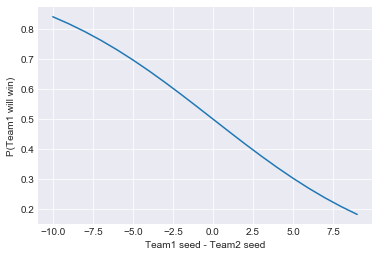

In [22]:
X = np.arange(-10, 10).reshape(-1, 1)
preds = clf.predict_proba(X)[:,1]

plt.plot(X, preds)
plt.xlabel('Team1 seed - Team2 seed')
plt.ylabel('P(Team1 will win)')

In [23]:
df_sample_sub = pd.read_csv('../Datasets/SampleSubmissionStage1.csv')
n_test_games = len(df_sample_sub)

def get_year_t1_t2(ID):
    """Return a tuple with ints `year`, `team1` and `team2`."""
    return (int(x) for x in ID.split('_'))

In [24]:
X_test = np.zeros(shape=(n_test_games, 1))
for ii, row in df_sample_sub.iterrows():
    year, t1, t2 = get_year_t1_t2(row.ID)
    t1_seed = df_seeds[(df_seeds.TeamID == t1) & (df_seeds.Season == year)].seed_int.values[0]
    t2_seed = df_seeds[(df_seeds.TeamID == t2) & (df_seeds.Season == year)].seed_int.values[0]
    diff_seed = t1_seed - t2_seed
    X_test[ii, 0] = diff_seed

In [25]:
preds = clf.predict_proba(X_test)[:,1]

clipped_preds = np.clip(preds, 0.05, 0.95)
df_sample_sub.Pred = clipped_preds
df_sample_sub.head()

,ID,Pred
0,2014_1107_1110,0.458264
1,2014_1107_1112,0.075159
2,2014_1107_1113,0.268154
3,2014_1107_1124,0.157979
4,2014_1107_1140,0.268154


# D Time Boogie.

### The plan:

- I want to build a scraper to pull in all the team season-long average stats.
- Then put those with each regular season game so that way the model can learn from the labels (W/L).
    - This should also include location to learn who is playing better on the road / neutral.
- Also (time permitting) I want to include the mascots by weight feature to make it a little different and fun.

In [91]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from time import sleep
import re

**Getting a list of the team names and their corresponding URLs:**

In [ ]:
res = requests.get('http://stats.ncaa.org/team/inst_team_list?academic_year=2017&conf_id=-1&division=1&sport_code=MBB')
soup = BeautifulSoup(res.content, 'lxml')

In [ ]:
giant_table = soup.find('div', {'class': 'css-panes'}).find('table')

In [ ]:
team_names = []
team_urls = []

In [ ]:
for column in giant_table.find_all('table'):
    for link in column.find_all('a'):
        team_names.append(link.text)
        team_urls.append('http://stats.ncaa.org/team' + str(link.attrs.get('href')))

**Trying to get a single team's stats:**

In [159]:
res = requests.get('http://stats.ncaa.org/teams/42595')
soup = BeautifulSoup(res.content, 'lxml')
res.status_code

200

In [231]:
stat_names = []
stat_values = []

for stat_name in soup.find_all('a', {'target': 'Rankings'}):
    stat_names.append(stat_name.text)
    
for i, x in enumerate(soup.find_all('td', {'align': 'right'})):
    if i % 2 != 0:
        stat_values.append(x.text)
        stat_values = [num.replace(" ", "") for num in stat_values]
        stat_values = [num.replace('\n', '') for num in stat_values]

**Now putting it all together into a scraper that will go into each team's URL**

In [233]:
team_stats = []

# starting_url = 'http://stats.ncaa.org/team/inst_team_list?academic_year=2017&conf_id=-1&division=1&sport_code=MBB'

def scrape_team_stats(url_list):
    missed_url_list = []
    for team in url_list:
        
        stat_values = []

        soup = BeautifulSoup(requests.get(team).content, 'html.parser')

        for i, x in enumerate(soup.find_all('td', {'align': 'right'})):
            if i % 2 != 0:
                stat_values.append(x.text)
                stat_values = [num.replace(" ", "") for num in stat_values]
                stat_values = [num.replace('\n', '') for num in stat_values]

        if stat_values != []:
            stat_values.append(team)
            team_stats.append(stat_values)
        else:
            missed_url_list.append(team)
                
    if len(missed_url_list) == 0:
        return team_stats
    else:
        return scrape_team_stats(missed_url_list)
            
scrape_team_stats(team_urls)

KeyboardInterrupt: 

**Don't forget to make a "difficulty by seed" feature!!!**

Very interesting to think about the difficulty of the path to the final that way, though I would've probably tried to weigh it by the probability that your team will face that seed in the next round instead of just assuming you will face the higher seed.

i mean use bayes - instead of saying the 5 auto plays the 4 next round say they get 12*probability 5 will win + 5* probability 12 will win